In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer

In [24]:
from src.DataPreparation import fc, ffc

In [25]:
ffc.count_documents({})

1270

In [26]:
ffc.find()[8]

{'_id': ObjectId('5c0d9d35baead16c7b79ba61'),
 'url': 'https://www.instagram.com/rozhy__musl__manakan',
 'bio': 'په يجى فه رمى رؤژى نوى🕋\n•___/\\___الله🕋❤️الله__/\\_____•\nته نهائاما نجمان خزمه ت كردنى زياتره به ئاينى بيرؤزى  ئيسلام🕋🕋\nسوباستان ده كين يارمتى مان كه ن',
 'followed_by': 1402,
 'follows': 3589,
 'num_posts': 10,
 'id': '2005449908',
 'is_joined_recently': False,
 'is_private': False,
 'is_business_account': True,
 'likes_last_post': 49,
 'avg_likes_five_recent_posts': 56.666666666666664}

In [27]:
df = pd.DataFrame(list(ffc.find()))

In [28]:
df.shape

(1270, 12)

In [29]:
df['likes_last_post'].fillna(0, inplace = True)

In [32]:
df['avg_likes_five_recent_posts'].fillna(0,inplace=True)

In [33]:
df.shape

(1270, 12)

In [34]:
df_dropped = df.dropna()

In [39]:
df_dropped.shape

(1195, 12)

In [36]:
df_dropped.head()

,_id,avg_likes_five_recent_posts,bio,followed_by,follows,id,is_business_account,is_joined_recently,is_private,likes_last_post,num_posts,url
0,5c0d9d34baead16c7b79ba01,9.000000,,63.0,76.0,8882294111,False,False,False,10.0,2.0,https://www.instagram.com/lirlando
1,5c0d9d34baead16c7b79ba03,128.333333,Haters make me famous😻\n@irvan740 ❤,870.0,136.0,7422647242,True,False,False,156.0,3.0,https://www.instagram.com/ndah.endah.3701
2,5c0d9d34baead16c7b79ba19,56.833333,Viaggia... a modo tuo! #Mazzone #Travel,2100.0,700.0,4091271053,True,False,False,26.0,180.0,https://www.instagram.com/mazzoneviaggi
3,5c0d9d34baead16c7b79ba1a,0.000000,,14.0,48.0,9418121438,False,True,False,0.0,0.0,https://www.instagram.com/chrismainahperre
6,5c0d9d35baead16c7b79ba3b,0.000000,@kha10lid_n,306.0,441.0,7311336467,False,False,True,0.0,21.0,https://www.instagram.com/khalid_malkk


In [38]:
df_dropped['is_business_account'] = df_dropped['is_business_account'].astype(int)
df_dropped['is_joined_recently'] = df_dropped['is_joined_recently'].astype(int)
df_dropped['is_private'] = df_dropped['is_private'].astype(int)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [40]:
df_dropped.head()

,_id,avg_likes_five_recent_posts,bio,followed_by,follows,id,is_business_account,is_joined_recently,is_private,likes_last_post,num_posts,url
0,5c0d9d34baead16c7b79ba01,9.000000,,63.0,76.0,8882294111,0,0,0,10.0,2.0,https://www.instagram.com/lirlando
1,5c0d9d34baead16c7b79ba03,128.333333,Haters make me famous😻\n@irvan740 ❤,870.0,136.0,7422647242,1,0,0,156.0,3.0,https://www.instagram.com/ndah.endah.3701
2,5c0d9d34baead16c7b79ba19,56.833333,Viaggia... a modo tuo! #Mazzone #Travel,2100.0,700.0,4091271053,1,0,0,26.0,180.0,https://www.instagram.com/mazzoneviaggi
3,5c0d9d34baead16c7b79ba1a,0.000000,,14.0,48.0,9418121438,0,1,0,0.0,0.0,https://www.instagram.com/chrismainahperre
6,5c0d9d35baead16c7b79ba3b,0.000000,@kha10lid_n,306.0,441.0,7311336467,0,0,1,0.0,21.0,https://www.instagram.com/khalid_malkk


In [12]:
df_dropped[58:59]

,_id,bio,followed_by,follows,id,is_business_account,is_joined_recently,is_private,likes_last_post,num_posts,url
70,5c098e41baead1a820a3d0cb,,7220.0,77.0,1400576780,0,0,0,226.0,345.0,https://www.instagram.com/yuliagarciafer


In [13]:
(df_dropped['likes_last_post'] != 0).sum() # number of users have likes on last post

659

In [14]:
plt.scatter?

In [41]:
df_dropped.describe()

,avg_likes_five_recent_posts,followed_by,follows,is_business_account,is_joined_recently,is_private,likes_last_post,num_posts
count,1195.000000,1195.000000,1195.000000,1195.00000,1195.000000,1195.000000,1195.000000,1195.000000
mean,90.066974,1429.941423,462.997490,0.21841,0.457741,0.124686,87.443515,51.033473
std,248.100021,4852.609305,954.381067,0.41334,0.498420,0.330501,374.120813,159.718703
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,39.500000,0.00000,0.000000,0.000000,0.000000,1.000000
50%,2.666667,84.000000,193.000000,0.00000,0.000000,0.000000,2.000000,3.000000
75%,59.083333,914.500000,482.000000,0.00000,1.000000,0.000000,49.000000,25.500000
max,2533.833333,82542.000000,7499.000000,1.00000,1.000000,1.000000,9925.000000,2433.000000


Text(0,0.5,'followed_by')

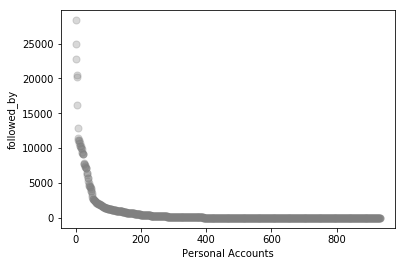

In [42]:
plt.scatter(x=np.linspace(0,934,934),y=sorted((df_dropped[df_dropped['is_business_account'] == 0].followed_by), reverse=True), alpha=0.3, color='grey', marker = 'o',s=50)
plt.xlabel('Personal Accounts')
plt.ylabel('followed_by')

In [91]:
df_dropped_followed_by = df_dropped[df_dropped['is_business_account'] == 0]['followed_by']

In [95]:
df_dropped_followed_by[df_dropped_followed_by > 20000].count()/len(df_dropped_followed_by)

0.0053533190578158455

Text(0,0.5,'log of frequency')

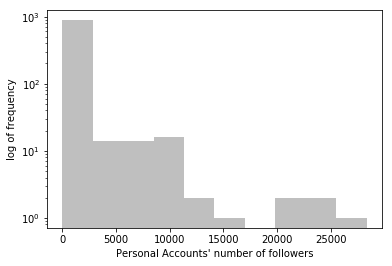

In [43]:
plt.hist(df_dropped[df_dropped['is_business_account'] == 0].followed_by, alpha=0.5, color='grey')
plt.xlabel("Personal Accounts' number of followers")
plt.gca().set_yscale("log")
plt.ylabel('log of frequency')

In [44]:
df_dropped.head()

,_id,avg_likes_five_recent_posts,bio,followed_by,follows,id,is_business_account,is_joined_recently,is_private,likes_last_post,num_posts,url
0,5c0d9d34baead16c7b79ba01,9.000000,,63.0,76.0,8882294111,0,0,0,10.0,2.0,https://www.instagram.com/lirlando
1,5c0d9d34baead16c7b79ba03,128.333333,Haters make me famous😻\n@irvan740 ❤,870.0,136.0,7422647242,1,0,0,156.0,3.0,https://www.instagram.com/ndah.endah.3701
2,5c0d9d34baead16c7b79ba19,56.833333,Viaggia... a modo tuo! #Mazzone #Travel,2100.0,700.0,4091271053,1,0,0,26.0,180.0,https://www.instagram.com/mazzoneviaggi
3,5c0d9d34baead16c7b79ba1a,0.000000,,14.0,48.0,9418121438,0,1,0,0.0,0.0,https://www.instagram.com/chrismainahperre
6,5c0d9d35baead16c7b79ba3b,0.000000,@kha10lid_n,306.0,441.0,7311336467,0,0,1,0.0,21.0,https://www.instagram.com/khalid_malkk


In [45]:
X = df_dropped.iloc[:,[1,3,4,7,8,9,10]]

In [46]:
X.shape

(1195, 7)

In [47]:
X.head()

,avg_likes_five_recent_posts,followed_by,follows,is_joined_recently,is_private,likes_last_post,num_posts
0,9.000000,63.0,76.0,0,0,10.0,2.0
1,128.333333,870.0,136.0,0,0,156.0,3.0
2,56.833333,2100.0,700.0,0,0,26.0,180.0
3,0.000000,14.0,48.0,1,0,0.0,0.0
6,0.000000,306.0,441.0,0,1,0.0,21.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


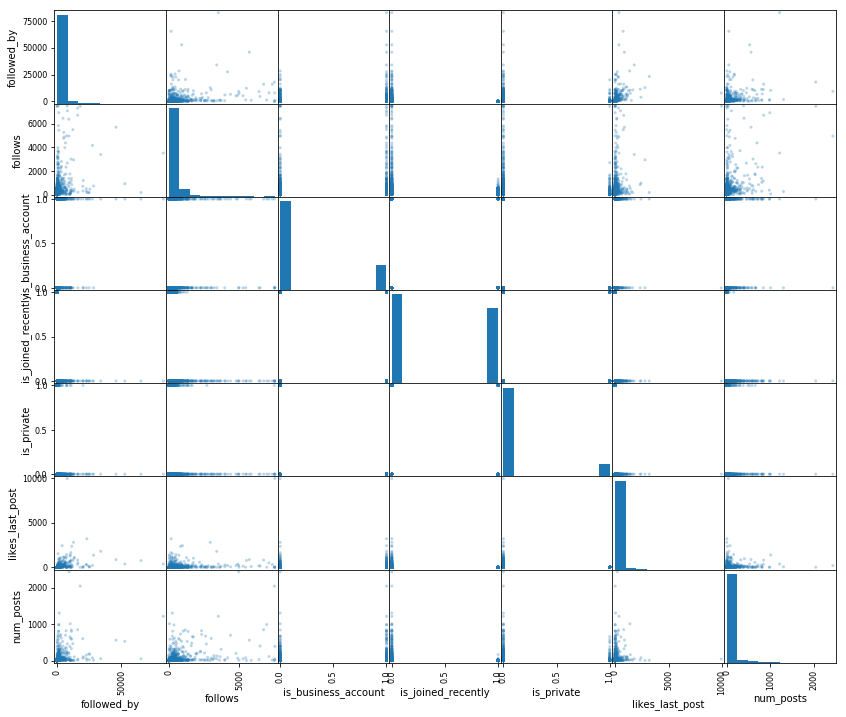

In [24]:
# _ = pd.scatter_matrix(df_dropped, alpha = 0.3, figsize=(14,12))

In [48]:
y = df_dropped.iloc[:, 6]

In [49]:
y.head()

0    0
1    1
2    1
3    0
6    0
Name: is_business_account, dtype: int64

In [50]:
y.shape

(1195,)

In [51]:
y.sum()

261

In [58]:
# of business accts: 261/1195 = 0.21841

### train-test split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((896, 7), (299, 7), (896,), (299,))

### Logistic Regression

In [54]:
model_logistic = LogisticRegression()

In [55]:
model_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
y_pred_logistic = model_logistic.predict_proba(X_test)[:,1]

In [57]:
log_loss_logistic = log_loss(y_test, y_pred_logistic)
log_loss_logistic

0.39165977446511796

In [58]:
cv_logloss = -cross_val_score(model_logistic, X, y, scoring = 'neg_log_loss', cv = 10).mean()
cv_logloss

0.39014862422073854

In [59]:
y_test_pred = pd.DataFrame({'actual':y_test,'prediction':y_pred_logistic})

# 'actual' == 0 means the account is actually not a business account, but y_pred high means 
# they are predicted to have high probability to be a business account
y_test_pred_filtered = y_test_pred[y_test_pred['actual']== 0]
y_test_pred_filtered[y_test_pred_filtered['prediction'] > 0.8]

,actual,prediction
924,0,0.925263


In [62]:
df_dropped.iloc[924, :]

_id                                                 5c0d9d3cbaead16c7b79be9c
avg_likes_five_recent_posts                                                0
bio                                                                         
followed_by                                                                0
follows                                                                   79
id                                                                9264431013
is_business_account                                                        0
is_joined_recently                                                         1
is_private                                                                 1
likes_last_post                                                            0
num_posts                                                                  0
url                            https://www.instagram.com/gjfjfjfjdhelerendon
Name: 994, dtype: object

### First Random Forest 

In [63]:
rf = RandomForestClassifier(n_estimators=100,
                            n_jobs=-1,
                            random_state=1)

In [64]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [65]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]

In [66]:
log_loss_rf = log_loss(y_test, y_pred_rf)
log_loss_rf

0.4721202096873282

In [67]:
cv_logloss_rf1 = -cross_val_score(rf, X, y, cv = 10, scoring = 'neg_log_loss').mean()
cv_logloss_rf1

0.5102002950428333

In [68]:
y_test_pred1 = pd.DataFrame({'actual':y_test,'prediction':y_pred_rf})
y_test_pred_filtered1 = y_test_pred1[y_test_pred1['actual']== 0]
y_test_pred_filtered1[y_test_pred_filtered1['prediction'] > 0.8]

,actual,prediction
77,0,0.81
688,0,0.86


In [69]:
y_test_pred_filtered1.describe()

,actual,prediction
count,239.0,239.000000
mean,0.0,0.146820
std,0.0,0.226556
min,0.0,0.000000
25%,0.0,0.000000
50%,0.0,0.010000
75%,0.0,0.205000
max,0.0,0.860000


### Best Random Forest

In [70]:
random_forest_grid = {'max_depth': [3, 4, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [40, 80, 100, 120, 140, 160],
                      'random_state': [359]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_log_loss')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  3.7min finished


best parameters: {'bootstrap': False, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 120, 'random_state': 359}


In [71]:
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=3, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
            oob_score=False, random_state=359, verbose=0, warm_start=False)

In [72]:
y_pred_best = best_rf_model.predict_proba(X_test)[:, 1]

In [73]:
y_test_pred2 = pd.DataFrame({'actual':y_test,'prediction':y_pred_best})
y_test_pred_filtered2 = y_test_pred2[y_test_pred2['actual']== 0]
y_test_pred_filtered2[y_test_pred_filtered2['prediction'] > 0.6]

,actual,prediction
70,0,0.611765
427,0,0.615264


In [74]:
log_loss_rf = log_loss(y_test, y_pred_best)
log_loss_rf

0.3544778556082339

In [75]:
cv_logloss_rf2 = -cross_val_score(best_rf_model, X, y, cv = 10, scoring = 'neg_log_loss').mean()
cv_logloss_rf2

0.35444179581224017

### Model Evaluation

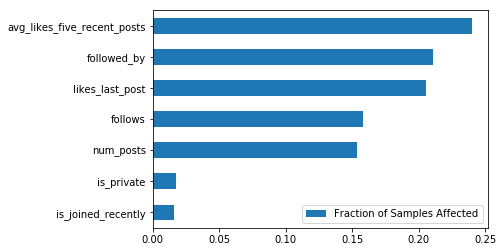

In [76]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')

(array([155.,  16.,  13.,   7.,   3.,   5.,  19.,  21.]),
 array([0.01410319, 0.08924828, 0.16439336, 0.23953845, 0.31468354,
        0.38982862, 0.46497371, 0.54011879, 0.61526388]),
 <a list of 8 Patch objects>)

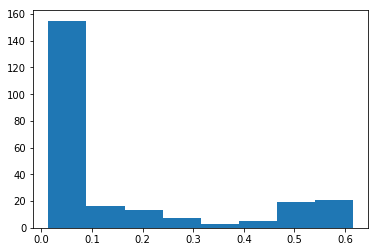

In [77]:
plt.hist(y_test_pred2[y_test_pred2['actual']== 0]['prediction'], bins = 8)

In [78]:
roc_auc_score(y_test, y_pred_best)

0.8483612273361227

In [79]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)

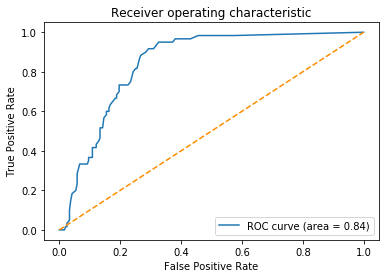

In [80]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_rf))
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [396]:
from src.DataPreparation import *

In [362]:
url = 'https://www.instagram.com/yuliagarciafer'

In [420]:
get_pred_one(url, best_rf_model)

array([0.6119541])

In [316]:
import pickle

In [317]:
# save the model to pickle
filename = 'finalized_model.sav'
pickle.dump(best_rf_model, open(filename, 'wb'))